# Generating a mixing which is a composition of radial map and conformal map

## 1. Actual data likelihood
## 2. Amari distance

In [1]:
import ima

In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from ima.residual import Residual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [3]:
key = jax.random.PRNGKey(1)

Introduce a perceptually uniform colormap (more colorblind friendly?).

In [4]:
import cmocean
cmap = cmocean.cm.phase
# Non-perceptually uniform alternative:
# cmap = 'hsv'

## Generate data

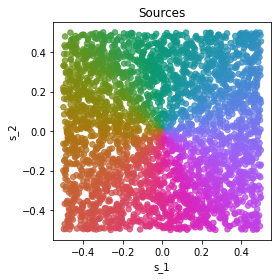

In [5]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5


from ima.plotting import cart2pol, pol2cart, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

# Insert here composition radial conformal maps!

In [6]:
from jax import vmap

In [7]:
from ima.mixing_functions import build_radial_map

In [8]:
radius = 3.0

In [9]:
# We shift and rescale the source domain
rescale =  np.diag(np.array([0.7,0.35]))
add = jnp.array([1.8, 0.6])
pol2cart_mixing, cart2pol_unmixing = build_radial_map(add, rescale)

In [10]:
a = jax.random.multivariate_normal(key, mean=np.zeros(D), cov=np.eye(D))
a /= jnp.mean(jnp.linalg.norm(a))
a *= radius

from ima.mixing_functions import build_moebius_transform

# Generate a 2d rotation matrix based on a rotation angle
angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
A = np.array([[c, -s], [s, c]])
b = 0.0 * np.ones(D) # a vector in \RR^D
alpha = 1.0
epsilon = 2.0

In [11]:
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b, epsilon=epsilon)

In [12]:
# b_new = b - np.mean(X, axis=0)

# mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b_new, epsilon=epsilon)

In [13]:
def composed_radial_moebius(s):
    x_1 = pol2cart_mixing(s)
    return mixing_moebius(x_1)

def composed_radial_moebius_inverse(x):
    s_1 = unmixing_moebius(x)
    return cart2pol_unmixing(s_1)

In [14]:
composed_radial_moebius_batched = vmap(composed_radial_moebius)
mixing_batched = composed_radial_moebius_batched

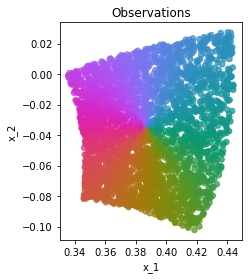

In [15]:
X = composed_radial_moebius_batched(S)
X_mean = np.mean(X, axis=0)
# X-= X_mean
scatterplot_variables(X[:,:2], 'Observations', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

In [16]:
unmixing_batched = vmap(composed_radial_moebius_inverse)

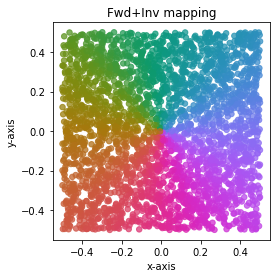

In [17]:
Y = unmixing_batched(X)
scatterplot_variables(Y[:,:2], 'Fwd+Inv mapping', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

# Check that for the composed transformation $C_{\operatorname{IMA}}=0$

In [18]:
from ima.metrics import cima

In [19]:
jac_inv_composed = vmap(jax.jacfwd(composed_radial_moebius_inverse))

In [20]:
np.mean(cima(X, jac_inv_composed))

DeviceArray(1.5894572e-10, dtype=float32)

## Set up model

In [21]:
n_layers = 10 #32
hidden_units = [40, 40] #[128, 128]

# I would substitute the Normal with a Logistic distribution

def log_prob(x):
    base_dist = distrax.Independent(distrax.Logistic(loc=jnp.zeros(D), scale=jnp.ones(D)),
                                                    reinterpreted_batch_ndims=1)
    flows = distrax.Chain([Residual(hidden_units + [D], name='residual_' + str(i))
                           for i in range(n_layers)])
    model = distrax.Transformed(base_dist, flows)
    return model.log_prob(x)

In [22]:
# Init model
logp = hk.transform(log_prob)
params = logp.init(key, jnp.array(np.random.randn(5, D)))

In [23]:
# In ML + C_IMA, we don't want triangular Jacobian! I comment out the below

# Make triangular
# masks = masks_triangular_weights([h // 2 for h in hidden_units])
# params = make_weights_triangular(params, masks)

In [24]:
# This is one part of the loss!
# Copied over from the triangular_residual_flow_test notebook

def inv_map_fn(x):
    flows = distrax.Chain([Residual(hidden_units + [D], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)

inv_map = hk.transform(inv_map_fn)

jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))



In [25]:
from ima.metrics import cima, cima_higher_d

In [26]:
# Apply spectral normalization

uv = spectral_norm_init(params, key)
params, uv = spectral_normalization(params, uv)

In [27]:
# Define a Lagrange multiplier to be multiplied before the c_ima contrast
lag_mult = 1.0

def loss(params, x):
    ll = logp.apply(params, None, x)
    # Compute the Jacobian based on current parameters
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
    # Compute C_IMA based on current Jacobian
#     c_ima = cima(x, jac_fn)
    c_ima = cima_higher_d(x, jac_fn)
    return -jnp.mean(ll) + lag_mult * jnp.mean(c_ima)

Model training

In [28]:
opt_init, opt_update, get_params = adam(step_size=1e-3)

@jax.jit
def step(it, opt_state, uv, x):
    params = get_params(opt_state)
#     params = make_weights_triangular(params, masks) # makes Jacobian triangular
    params, uv = spectral_normalization(params, uv)
    params_flat = jax.tree_util.tree_flatten(params)[0]
    for ind in range(len(params_flat)):
        opt_state.packed_state[ind][0] = params_flat[ind]
    value, grads = jax.value_and_grad(loss, 0)(params, x)
    opt_out = opt_update(it, grads, opt_state)
    return value, opt_out, uv

In [29]:
iters, batch_size = 50000, 256

opt_state = opt_init(params)

loss_hist = np.array([])

In [30]:
for i in range(iters):
    x = X[np.random.choice(X.shape[0], batch_size)]
    value, opt_state, uv = step(i, opt_state, uv, x)
    loss_hist = np.append(loss_hist, value.item())
    if i%2000==0:
        params = get_params(opt_state)
        jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
        c_ima = cima_higher_d(x, jac_fn)
        print("iter=", i, "; loss=", value.item(), 
              "; -log-p=", -jnp.mean(logp.apply(params, None, x)), "; cima=", jnp.mean(c_ima)#,
#              "; loss=", -jnp.mean(logp.apply(params, None, x)) + lag_mult*jnp.mean(c_ima)
             )

iter= 0 ; loss= 2.8097829818725586 ; -log-p= 2.7990038 ; cima= 8.847928e-08
iter= 2000 ; loss= -4.0674147605896 ; -log-p= -4.106317 ; cima= 0.0020126365
iter= 4000 ; loss= -4.022939682006836 ; -log-p= -4.0095124 ; cima= 0.0044259652
iter= 6000 ; loss= -4.162500381469727 ; -log-p= -4.1656084 ; cima= 0.0024120994
iter= 8000 ; loss= -4.15657377243042 ; -log-p= -4.176153 ; cima= 0.0028434172
iter= 10000 ; loss= -4.115198612213135 ; -log-p= -4.1395016 ; cima= 0.002841942
iter= 12000 ; loss= -4.169426918029785 ; -log-p= -4.1712937 ; cima= 0.003326945
iter= 14000 ; loss= -4.036709308624268 ; -log-p= -4.1190886 ; cima= 0.004120812
iter= 16000 ; loss= -4.215548515319824 ; -log-p= -4.203685 ; cima= 0.0020017568
iter= 18000 ; loss= -4.117490291595459 ; -log-p= -4.196639 ; cima= 0.003283115
iter= 20000 ; loss= -4.136617183685303 ; -log-p= -4.150506 ; cima= 0.0032437537
iter= 22000 ; loss= -4.108729362487793 ; -log-p= -4.0649076 ; cima= 0.0042975396
iter= 24000 ; loss= -4.28487491607666 ; -log-p= -

In [31]:
params_final = get_params(opt_state)
# params_final = make_weights_triangular(params_final, masks)
params_final, _ = spectral_normalization(params_final, uv)

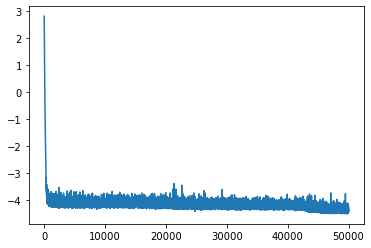

In [32]:
from matplotlib import pyplot as plt

plt.plot(loss_hist)

In [33]:
def inv_map_fn(x):
    flows = distrax.Chain([Residual(hidden_units + [D], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)
inv_map = hk.transform(inv_map_fn)

In [34]:
S_rec = inv_map.apply(params_final, None, X)

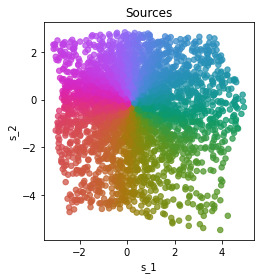

In [35]:
scatterplot_variables(S_rec[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [36]:
from jax.scipy.stats import logistic

In [37]:
S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

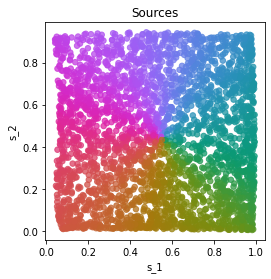

In [38]:
scatterplot_variables(S_unif[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

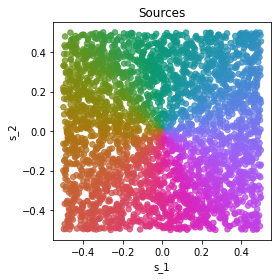

In [39]:
scatterplot_variables(S[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

## Compute CIMA

In [40]:
# def cima(x):
#     jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
#     J = jac_fn(x)
#     detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
#     out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
#     return out

In [41]:
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
# c = cima(X, jac_fn)

In [42]:
# jnp.mean(c)

In [43]:
c_hd = cima_higher_d(X, jac_fn)
jnp.mean(c_hd)

DeviceArray(0.0025553, dtype=float32)

In [44]:
# Check that the Jacobian is **not** triangular
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

[[74.82897   -1.7292123]
 [-0.3327739 71.40201  ]]


In [45]:
# for i in range(2):
#     for j in range(2):
#         plt.plot(J[i,j])
#         plt.title(str(i)+","+str(j))
#         plt.show()

In [46]:
# Use the Amari distance for evaluation

## Amari distance evaluation

Rather than the average of the Amari distances between the products of the Jacobians, we should take the Amari distance of the average of the products of the Jacobians.
Otherwise it is hard to account for the fact that the Permutation matrix might be different at different locations

In [47]:
from ima.metrics import jacobian_amari_distance

In [48]:
# Sample P a permutation matrix
Perm = np.array([[0,1],[1,0]])# a permutation matrix

def composed_function(x):
    y = composed_radial_moebius_inverse(x)
    y = y @ Perm
    z = jnp.tanh(y)
    return z

In [49]:
jac_r_unmix = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_r_unmix = jax.jacfwd(composed_radial_moebius_inverse)
# jac_r_unmix = jax.jacfwd(composed_function)
jac_t_mix = jax.jacfwd(composed_radial_moebius)

In [50]:
jac_r_unmix_vmap = jax.vmap(jac_r_unmix)
jac_t_mix_vmap = jax.vmap(jac_t_mix)

In [51]:
jad = jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched)

In [52]:
print(jad)

0.014626069


In [53]:
# To do: Visualize the distortion from original sources to reconstructed ones?
# Maybe with a gridplot?

In [54]:
jac_fn = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_fn = jax.jacfwd(composed_radial_moebius_inverse)
# jac_fn = jax.jacfwd(composed_function)

In [55]:
jac_fn_batched = vmap(jac_fn)

In [56]:
c_hd = cima_higher_d(X, jac_fn_batched)
jnp.mean(c_hd)

DeviceArray(0.0025553, dtype=float32)

In [57]:
c = cima(X, jac_fn_batched)
jnp.mean(c)

DeviceArray(0.00255531, dtype=float32)

In [58]:
jnp.mean(jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched))

DeviceArray(0.01462607, dtype=float32)

## MCC based evaluation

In [59]:
from ima.solve_hungarian import SolveHungarian

In [60]:
import numpy as np
from scipy.stats import spearmanr
from scipy.optimize import linear_sum_assignment

def SolveHungarian( recov, source, correlation='Pearson' ):
    """
    compute maximum correlations between true indep components and estimated components 
    """
    Ncomp = source.shape[1]
    if correlation == 'Pearson':
        CorMat = (np.abs(np.corrcoef( recov.T, source.T ) ) )[:Ncomp, Ncomp:]
    elif correlation == 'Spearman':
        rho, _ = np.abs(spearmanr( recov, source ) )
        CorMat = rho[:Ncomp, Ncomp:]
    ii = linear_sum_assignment( -1*CorMat )

    return CorMat[ii].mean(), CorMat, ii

In [61]:
av_corr_spearman, _, indices = SolveHungarian(recov=S_unif, source=S, correlation = 'Spearman')
print('Spearman correlation true-recovered sources: ', av_corr_spearman)

av_corr_pearson, _, indices = SolveHungarian(recov=S_unif, source=S, correlation = 'Pearson')
print('Pearson correlation true-recovered sources: ', av_corr_pearson)

Spearman correlation true-recovered sources:  0.9968765022639012
Pearson correlation true-recovered sources:  0.9963751570746124


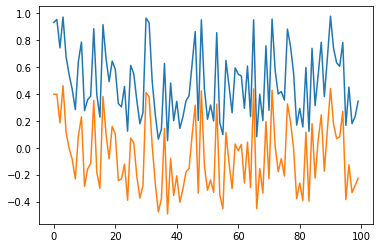

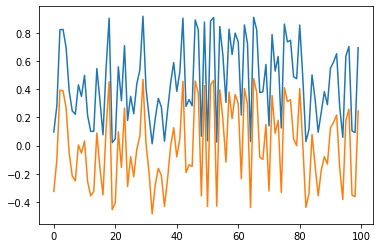

In [62]:
plt.figure()
end = 100
for i in range(S.shape[1]):
    plt.plot(S_unif[:end,indices[0][i]])
    plt.plot(S[:end, indices[1][i]])
    plt.show()